### Pytania: 
1. W jaki sposób przetworzyć w tym przypadku dane kategorialne? Istnieje MCA, czyli PCA dla kategorialnych 
2. Jakie porównania robić między sobą
3. Czy badać pod kątem zbalansowania?
4. Czy użyć WEKI np. do porównania, czy warto

In [1]:
%matplotlib inline

In [116]:
import pandas as pd
from pathlib import Path 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import prince
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from ai_data_eng.machine_learning.viz import *
from ai_data_eng.machine_learning.utils import *
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

DATA_DIR = Path("../../data")

In [3]:
dataset = pd.read_csv(DATA_DIR / 't-shirts.csv')

In [4]:
dataset.head()

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium


Cechy zostały podzielone na nominalne, czyli bez uporządkowania między nimi, oraz na porządkowe, gdyż możemy ustalić porządek między wartościami. 

In [5]:
nominal = ['material', 'color']
ordinal = ['size', 'sleeves']

features = nominal + ordinal

goal = 'demand'

labels = dataset[goal].drop_duplicates().values.tolist()
labels

['medium', 'high', 'low']

In [6]:
size_labels = ['XS', 'S', 'M' ,'L', 'XL', 'XXL', '3XL']
sleeves_labels = ['short', 'long']

## Eksploracja danych 

Dane są pełne i w całości kategorialne. Większość kategori, oprócz sleeves, jest niezbalansowanych. Będzie to prawdopodobnie miało wpływ na niektóre algorytmy. Jako że są to dane kategorialne, to jedyną ciekawą statystyką jest częstość występowania wartości w danych kategoriach, oraz korelacja (współwystępowanie) z innymi wartościami. Oprócz zmiennej którą chcemy przewidywać nie ma korelacji między atrybutami, co może być istotne w kontekście założeń niektóych algorytmów. 

Kategoria 'demand' jest zmienną, którą chcemy przewidzieć. 

In [7]:
profile = ProfileReport(dataset, title = "T Shirts Report")

In [8]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Rozkład cech ze względu na przypisaną kategorię

<Axes: xlabel='sleeves', ylabel='count'>

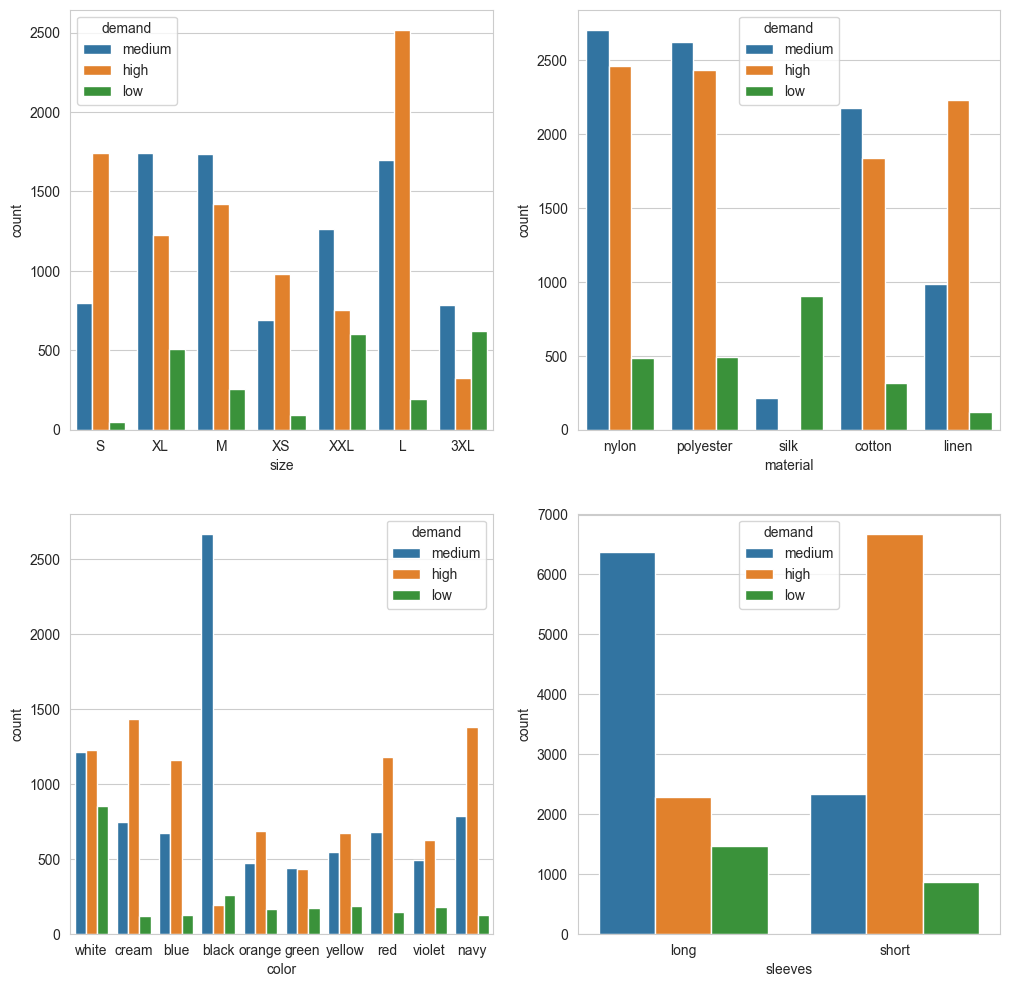

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.countplot(dataset, x='size', hue=dataset[goal], ax=axes[0, 0])
sns.countplot(dataset, x='material', hue=dataset[goal], ax=axes[0, 1])
sns.countplot(dataset, x='color', hue=dataset[goal], ax=axes[1, 0])
sns.countplot(dataset, x='sleeves', hue=dataset[goal], ax=axes[1, 1])

### Podział danych na zbiory

In [10]:
dataset.head()

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium


In [11]:
from sklearn.model_selection import train_test_split

# Could add stratification
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, stratify=dataset[goal], random_state=42)

In [12]:
print(f'{train_dataset.size}, {test_dataset.size}')

75000, 25000


Wykorzystany został podział z warstwami ze względu na liczność klas docelowych 

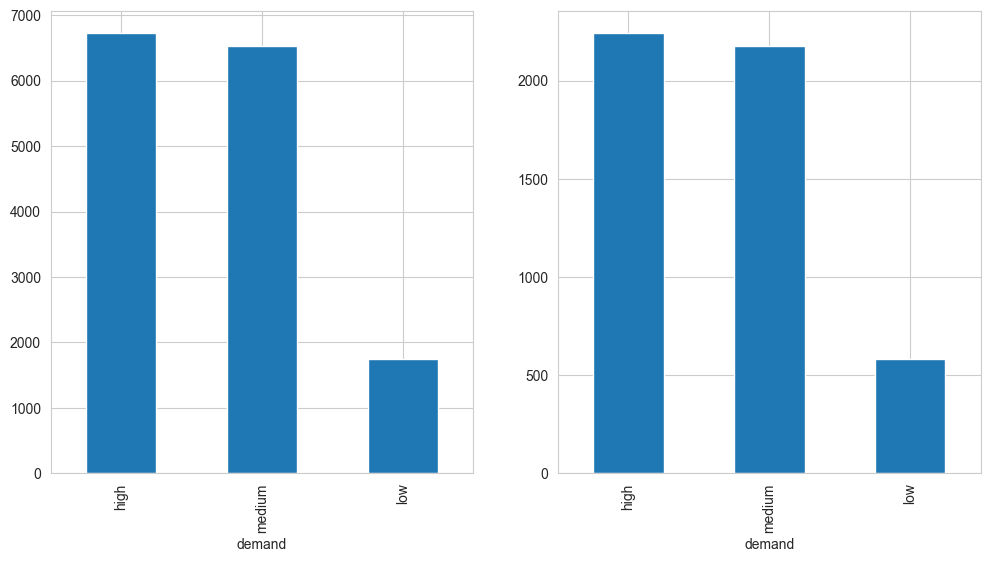

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_dataset[goal].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
test_dataset[goal].value_counts().plot(kind='bar')
plt.show()

In [14]:
features_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [15]:
preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', features_pipeline, features)
])

### Naiwny Bayes

In [16]:
from sklearn.naive_bayes import CategoricalNB

complete_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB())
])

In [17]:
complete_pipeline.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [18]:
score = complete_pipeline.score(test_dataset[features], test_dataset[goal])

In [19]:
score

0.831

In [20]:
cat_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'alpha': [1.0, 0.5],
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

cat_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', cat_nb_grid_search)
])

cat_nb_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'alpha': [1.0, 0.5],
                                          'class_prior': [None,
                                                          [0.5, 0.1, 0.4]],
                                          'fit_prior': [True, False]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

O dziwo klasyfikator działa odrobinę lepiej, gdy nie są używane prawdopodobieństwa a priori 

In [21]:
cat_res = pd.DataFrame.from_dict(cat_nb_gs_pipeline.named_steps['estimator'].cv_results_)

In [22]:
cat_res[['param_alpha', 'param_class_prior', 'param_fit_prior', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

,param_alpha,param_class_prior,param_fit_prior,mean_test_accuracy,mean_test_balanced_accuracy
0,1.0,None,True,0.811867,0.710542
1,1.0,None,False,0.815267,0.829481
2,1.0,"[0.5, 0.1, 0.4]",True,0.808267,0.705273
3,1.0,"[0.5, 0.1, 0.4]",False,0.808267,0.705273
4,0.5,None,True,0.811867,0.710542
5,0.5,None,False,0.815267,0.829481
6,0.5,"[0.5, 0.1, 0.4]",True,0.808267,0.705273
7,0.5,"[0.5, 0.1, 0.4]",False,0.808267,0.705273


In [23]:
cat_nb_pipe_2 = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB(class_prior=None, fit_prior=True))
])

cat_nb_pipe_2.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [24]:
confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels=labels)

array([[1772,  112,  293],
       [ 309, 1848,   84],
       [  64,    0,  518]], dtype=int64)

In [25]:
class_accuracy(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels)

array([0.81396417, 0.82463186, 0.89003436])

In [26]:
melted = long_form_results(test_dataset[features], test_dataset[goal], labels, [cat_nb_gs_pipeline, cat_nb_pipe_2], ['NB 1', 'NB 2'])

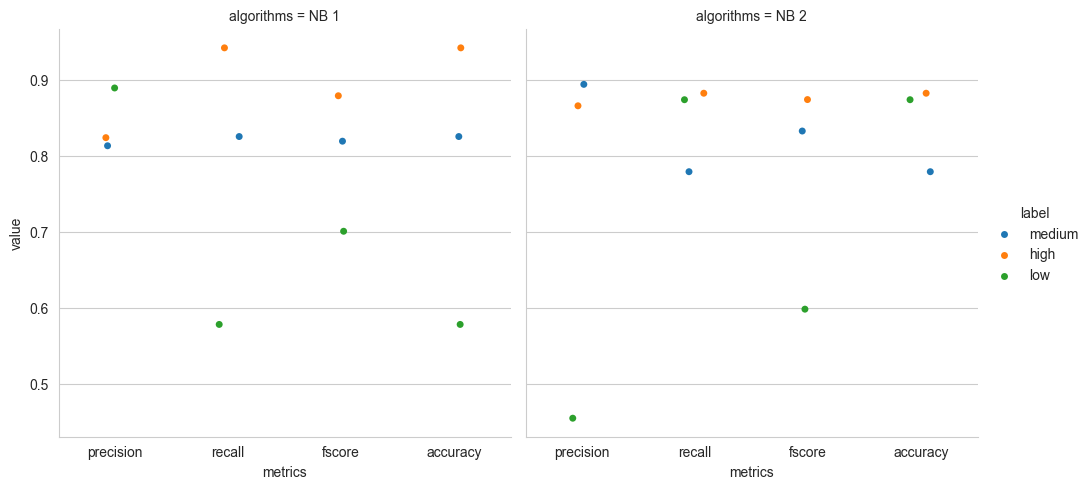

In [27]:
sns.catplot(melted, y='value', x='metrics', hue='label', col='algorithms')

<Axes: xlabel='metrics', ylabel='value'>

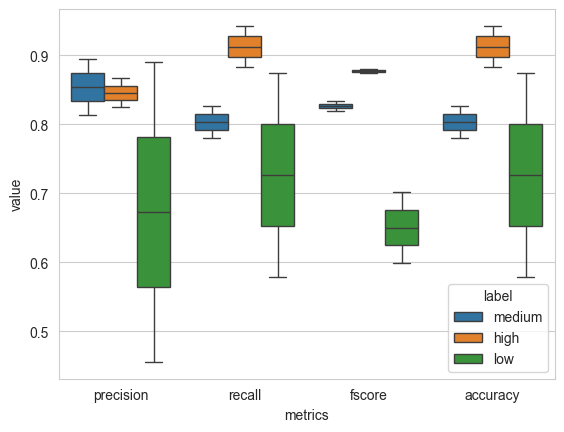

In [28]:
sns.boxplot(melted, y='value', x='metrics', hue='label')

In [29]:
confusion_matrix(test_dataset[goal], cat_nb_pipe_2.predict(test_dataset[features]), labels=labels)

array([[1948,  191,   38],
       [ 299, 1942,    0],
       [ 251,   66,  265]], dtype=int64)

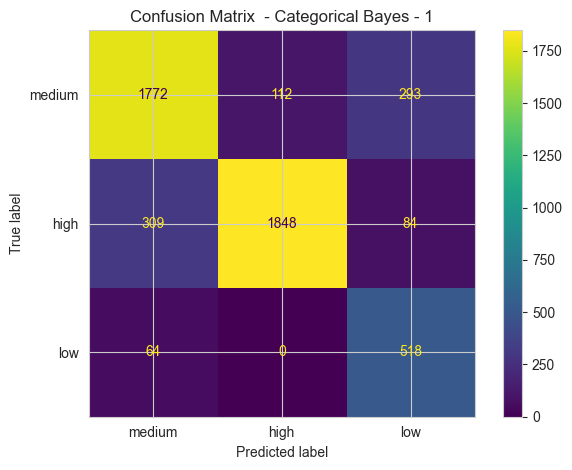

In [30]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes - 1')

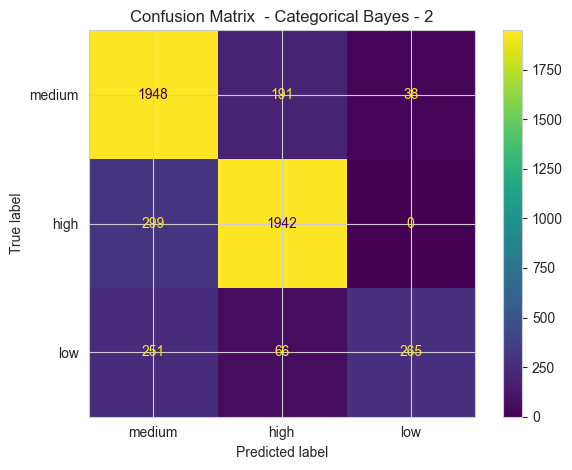

In [51]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_pipe_2.predict(test_dataset[features]), labels, 'Categorical Bayes - 2')

Między tymi dwoma algorytmami widać też zależność między recall a precision - jedno z nich jest bardziej dokładne kosztem drugiego

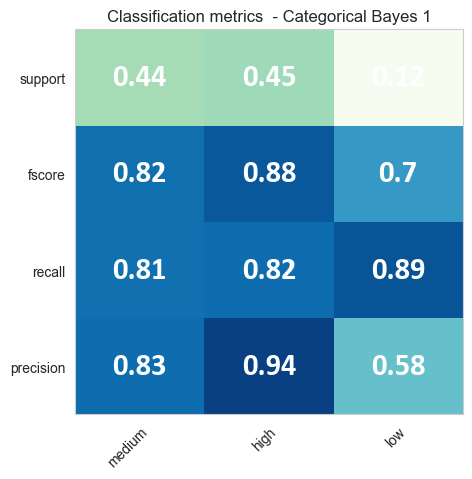

In [32]:
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes 1')

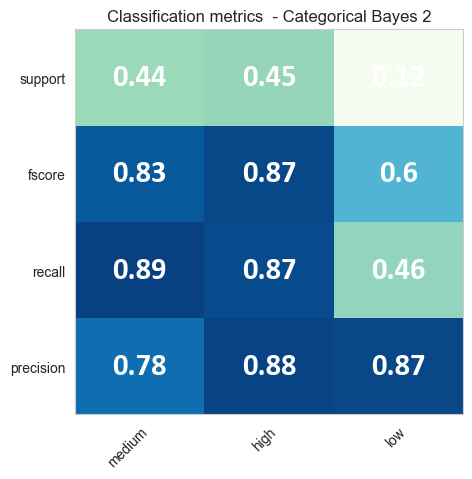

In [33]:
visualize_classification_metrics(test_dataset[goal], cat_nb_pipe_2.predict(test_dataset[features]), labels, 'Categorical Bayes 2')


In [34]:
recall_score(test_dataset[goal], cat_nb_pipe_2.predict(test_dataset[features]), average='macro')

0.7389044173230009

### Drzewo decyzyjne

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
dt_clf_pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', DecisionTreeClassifier(random_state=42))
])

dt_clf_pipe.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', DecisionTreeClassifier(random_state=42))])

In [80]:
precision_recall_fscore_support(test_dataset[goal], dt_clf_pipe.predict(test_dataset[features]), labels=labels)

(array([0.96303058, 0.9821269 , 0.95271454]),
 array([0.9692237 , 0.98081214, 0.9347079 ]),
 array([0.96611722, 0.98146908, 0.94362533]),
 array([2177, 2241,  582], dtype=int64))

In [81]:
clf = dt_clf_pipe.named_steps['estimator']
clf

DecisionTreeClassifier(random_state=42)

In [82]:
clf.tree_.max_depth

17

[Text(0.6245899283008658, 0.9722222222222222, 'x[3] <= 0.5\ngini = 0.596\nsamples = 15000\nvalue = [6724, 1744, 6532]'),
 Text(0.41882271374458874, 0.9166666666666666, 'x[0] <= 3.5\ngini = 0.536\nsamples = 7588\nvalue = [1737, 1109, 4742]'),
 Text(0.5217063210227273, 0.9444444444444444, 'True  '),
 Text(0.1774722673160173, 0.8611111111111112, 'x[2] <= 0.5\ngini = 0.509\nsamples = 7164\nvalue = [1737, 783, 4644]'),
 Text(0.06168831168831169, 0.8055555555555556, 'x[1] <= 4.5\ngini = 0.5\nsamples = 617\nvalue = [0, 314, 303]'),
 Text(0.030303030303030304, 0.75, 'x[0] <= 1.5\ngini = 0.426\nsamples = 312\nvalue = [0, 96, 216]'),
 Text(0.017316017316017316, 0.6944444444444444, 'x[0] <= 0.5\ngini = 0.5\nsamples = 132\nvalue = [0, 64, 68]'),
 Text(0.008658008658008658, 0.6388888888888888, 'x[1] <= 0.5\ngini = 0.494\nsamples = 63\nvalue = [0, 35, 28]'),
 Text(0.004329004329004329, 0.5833333333333334, 'gini = 0.0\nsamples = 28\nvalue = [0, 0, 28]'),
 Text(0.012987012987012988, 0.5833333333333334

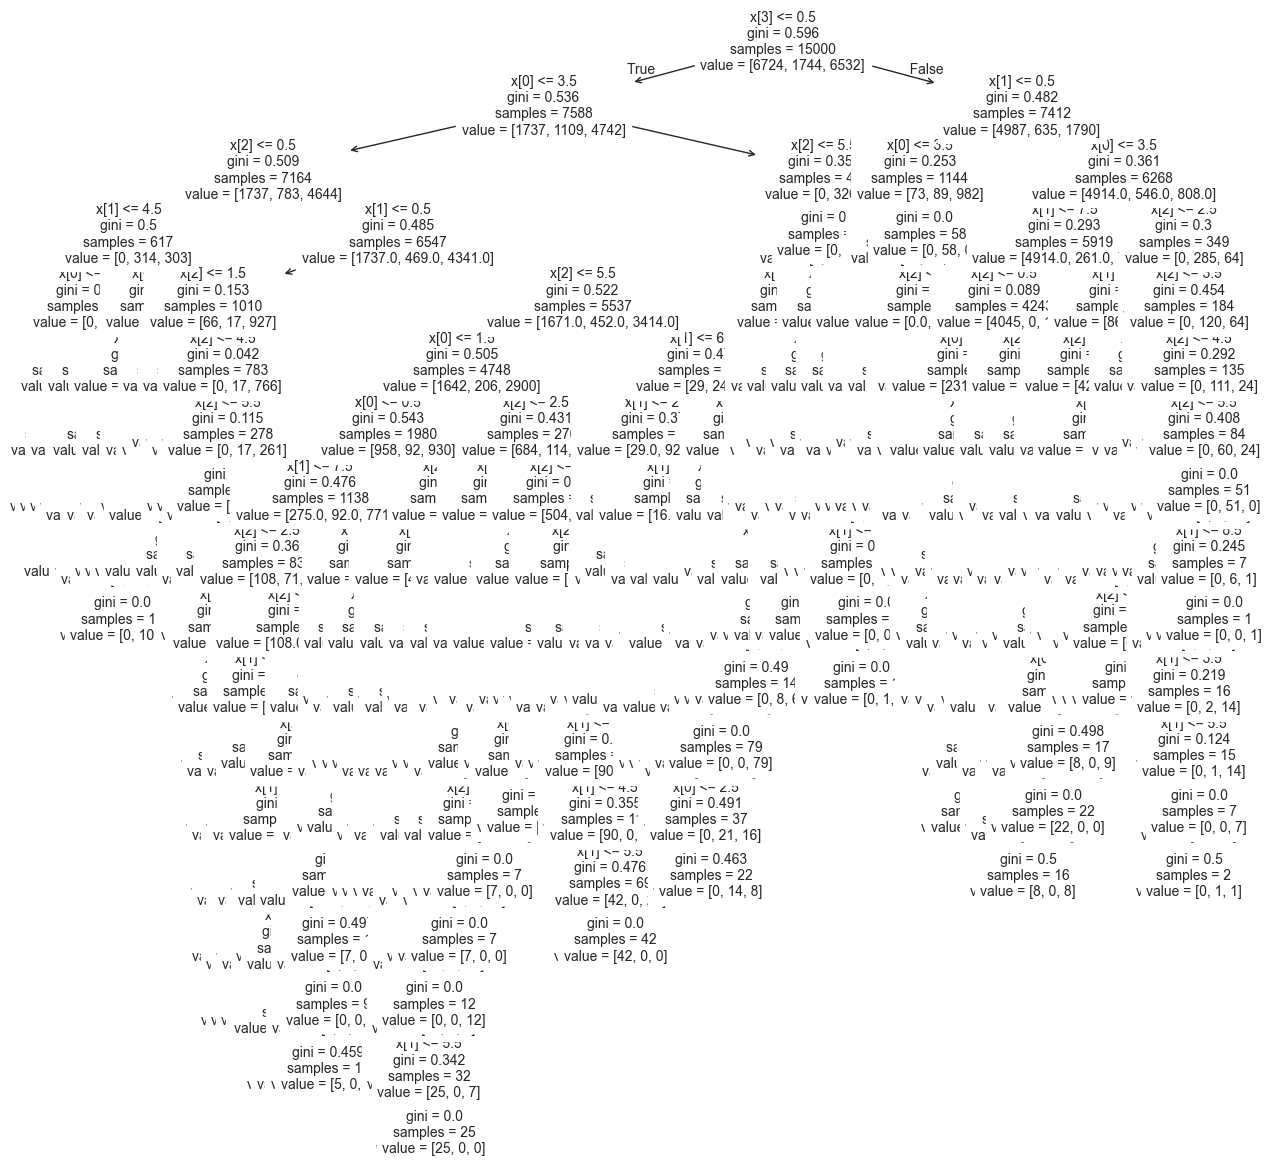

In [83]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(clf, ax=ax, fontsize=10)

In [84]:
from sklearn.tree import DecisionTreeClassifier

dt_clf_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid={
                      'max_depth': [None, 6, 12],
                      'min_samples_leaf': [1, 2, 5],
                      'max_features': [None, 'log2']
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

dt_clf_gd_pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', dt_clf_grid_search)
])

dt_clf_gd_pipe.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(random_state=42),
                              param_grid={'max_depth': [None, 6, 12],
                                          'max_features': [None, 'log2'],
                                          'min_samples_leaf': [1, 2, 5]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [85]:
dt_res = pd.DataFrame.from_dict(dt_clf_gd_pipe.named_steps['estimator'].cv_results_)

In [86]:
dt_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy',
       'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy',
       'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy',
       'std_test_balanced_accuracy', 'rank_test_balanced_accuracy'],
      dtype='object')

#### Analiza wyników przeszukiwania

Najlepsze wyniki (> 0.96) osiągnęły drzewa o maksymalnej możliwej głębokości (tutaj to mogło być 17). Następnie gorsze wyniki mają drzewa z większymi liśćmi. Po piętach depczą im drzewa o mniejszej maksymalnej głębokości (12) o wynikach ok. 0.95. Dla maksymalnej głębokości 6 wyniki są już drastycznie gorsze, bo poniżej 0.8. 

In [87]:
dt_res[['param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'mean_test_accuracy', 'mean_test_balanced_accuracy']]

,param_max_depth,param_max_features,param_min_samples_leaf,mean_test_accuracy,mean_test_balanced_accuracy
0,NaN,None,1,0.967200,0.960783
1,NaN,None,2,0.967000,0.960350
2,NaN,None,5,0.965600,0.958868
3,NaN,log2,1,0.966800,0.959917
4,NaN,log2,2,0.966067,0.958656
5,NaN,log2,5,0.964067,0.956151
6,6.0,None,1,0.798733,0.742445
7,6.0,None,2,0.798733,0.742445
8,6.0,None,5,0.798733,0.742445
9,6.0,log2,1,0.796733,0.719444


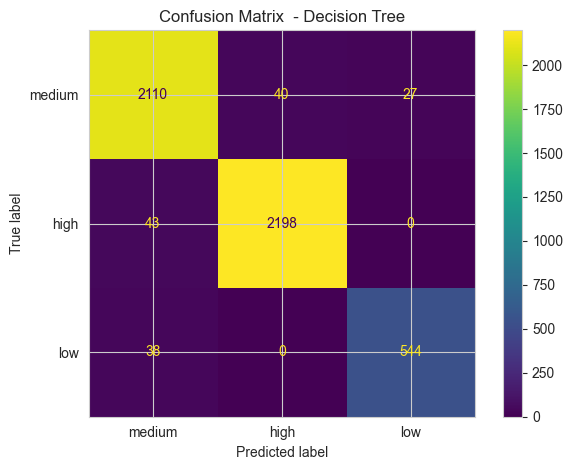

In [93]:
visualize_confusion_matrix(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels=labels, name='Decision Tree')

Klasa o najmniejszej liczności ma trochę gorsze metryki

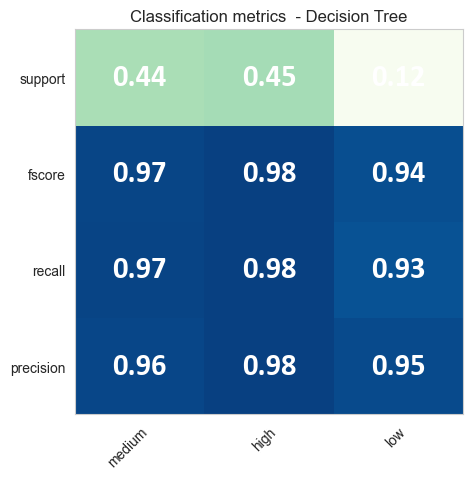

In [94]:
visualize_classification_metrics(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels=labels, name='Decision Tree')

In [168]:
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(train_dataset[features])

In [169]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.262,5.24%,5.24%
1,0.258,5.17%,10.40%
2,0.257,5.14%,15.54%


In [170]:
mca.row_coordinates(train_dataset[features]).head()

,0,1,2
3152,0.808603,-0.062210,0.630567
2950,-0.438303,-0.082680,0.158228
7761,-0.162606,0.249631,0.147708
11332,-0.210040,-0.075025,-0.013125
1172,0.524016,-0.859435,-0.343115


In [171]:
mca_train_dataset = pd.merge(train_dataset[goal], mca.row_coordinates(train_dataset[features]), left_index=True, right_index=True)

<Axes: xlabel='0', ylabel='1'>

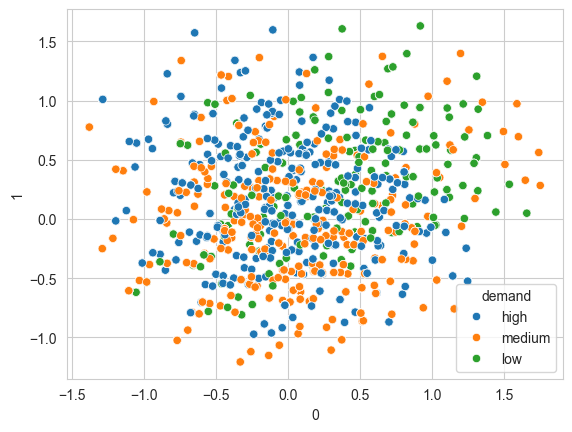

In [172]:
sns.scatterplot(mca_train_dataset, x=0, y=1, hue='demand')

In [173]:
mca.row_coordinates(train_dataset[features])

,0,1,2
3152,0.808603,-0.062210,0.630567
2950,-0.438303,-0.082680,0.158228
7761,-0.162606,0.249631,0.147708
11332,-0.210040,-0.075025,-0.013125
1172,0.524016,-0.859435,-0.343115
...,...,...,...
17606,-0.518859,0.888929,0.303982
8605,-0.324106,-0.512526,-0.408897
1078,-0.156007,-0.024229,-0.299827
8096,-0.113573,-0.962889,-0.008567


In [175]:
mca.column_coordinates(train_dataset[features])

,0,1,2
material_cotton,-0.142701,0.051441,-0.101792
material_linen,-0.622275,0.801413,-0.341469
material_nylon,-0.245927,0.078066,0.350784
material_polyester,0.441026,-0.774298,-0.020455
material_silk,1.471430,0.869434,-0.232682
color_black,0.482323,-0.245311,0.514996
color_blue,-0.004758,-0.489163,-1.294905
color_cream,0.099822,1.164866,0.601312
color_green,-0.825879,-0.972432,-0.220438
color_navy,0.900308,0.301282,-0.973365


In [176]:
import altair as alt
alt.data_transformers.enable("vegafusion")

mca.plot(
    train_dataset[features],
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [177]:
mca.column_contributions_.head().style.format('{:.0%}')

,0,1,2
material_cotton,0%,0%,0%
material_linen,6%,10%,2%
material_nylon,2%,0%,3%
material_polyester,5%,16%,0%
material_silk,11%,4%,0%


In [178]:
mca.row_cosine_similarities(train_dataset[features]).head()

,0,1,2
3152,0.122398,0.000724,0.074433
2950,0.029908,0.001064,0.003898
7761,0.006606,0.015570,0.005451
11332,0.011754,0.001500,0.000046
1172,0.054034,0.145347,0.023166


In [179]:
mca.column_cosine_similarities(train_dataset[features]).head()

,0,1,2
material_cotton,0.005692,0.000740,0.002896
material_linen,0.078078,0.129502,0.023511
material_nylon,0.023489,0.002367,0.047789
material_polyester,0.075116,0.231538,0.000162
material_silk,0.126982,0.044334,0.003175


In [181]:
from sklearn.svm import LinearSVC

mca_features_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

svc_preprocessing_pipeline = ColumnTransformer([
    ('numerical_preprocessor', mca_features_pipeline, [0, 1, 2])
])

svc_pipeline = Pipeline([
    ('preprocessor', svc_preprocessing_pipeline),
    ('classifier', LinearSVC(random_state=42))
])

In [183]:
svc_pipeline.fit(mca.row_coordinates(train_dataset[features]), mca_train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2])])),
                ('classifier', LinearSVC(random_state=42))])

In [184]:
svc_pipeline.named_steps['classifier'].coef_

array([[-0.01031784,  0.17229677, -0.29641437],
       [ 0.04834995,  0.05143714,  0.05375137],
       [-0.03849997, -0.22355996,  0.24208004]])

In [185]:
accuracy_score(test_dataset[goal], svc_pipeline.predict(mca.row_coordinates(test_dataset[features])))

0.5834

C:\Users\julia\VSCode\AI-and-Data-Engineering\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


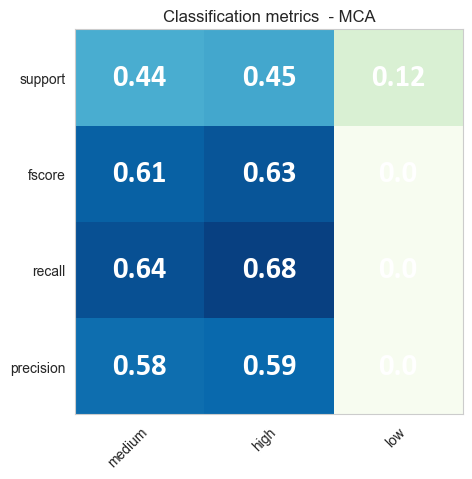

In [186]:
visualize_classification_metrics(test_dataset[goal], svc_pipeline.predict(mca.row_coordinates(test_dataset[features])),
                                 labels=labels, name='MCA')

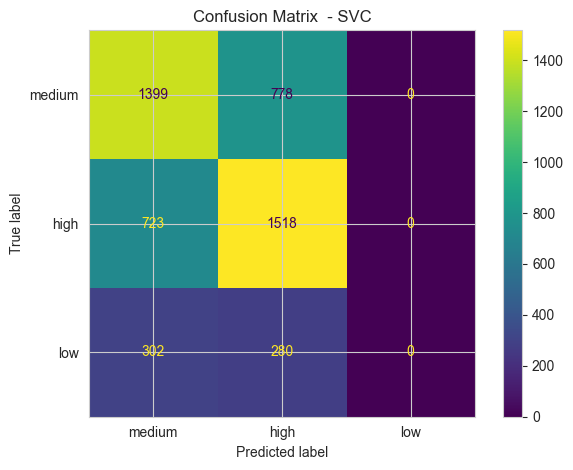

In [207]:
visualize_confusion_matrix(test_dataset[goal], svc_pipeline.predict(mca.row_coordinates(test_dataset[features])), labels=labels, name='SVC')

In [189]:
from sklearn.svm import SVC 

svc_grid_search = GridSearchCV(estimator=SVC(random_state=42),
                  param_grid={
                      'C': [0.1, 1, 2],
                      'kernel': ['linear', 'poly', 'rbf'],
                      'class_weight': ['balanced', None]
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')
    
svc_gd_pipeline = Pipeline([
    ('preprocessor', svc_preprocessing_pipeline),
    ('classifier', svc_grid_search)
])

svc_gd_pipeline.fit(mca.row_coordinates(train_dataset[features]), mca_train_dataset[goal])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2])])),
                ('classifier',
                 GridSearchCV(cv=5, estimator=SVC(random_state=42),
                              param_grid={'C': [0.1, 1, 2],
                                          'class_weight': ['balanced', None],
                                          'kernel': ['linear', 'poly', 'rbf']},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [190]:
svc_res = pd.DataFrame.from_dict(svc_gd_pipeline.named_steps['classifier'].cv_results_)

In [194]:
svc_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_kernel', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy',
       'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy',
       'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy',
       'std_test_balanced_accuracy', 'rank_test_balanced_accuracy'],
      dtype='object')

In [191]:
svc_gd_pipeline.predict(mca.row_coordinates(test_dataset[features]))

array(['medium', 'medium', 'medium', ..., 'high', 'medium', 'high'],
      dtype=object)

In [196]:
class SVCWrapper:
    
    def __init__(self, clf):
        self.clf = clf
    
    def predict(self, X):
        return self.clf.predict(mca.row_coordinates(X))

#### Analiza wyników przeszukiwania

MCA posłużyło jako PCA, tylko dla danych kategorialnych. Zostały przetestowany SVC z różnymi rodzajami kernel'i i wartościami regularyzacji. Najlepsze wartości osiągnął kernel 'rbf', gdzie faworyzowane były przebiegi bez wag dla klas. Warto zauważyć, że zbalansowana dokładność jest o wiele gorsza i osiąga czasem wyniki nawet gorsze niż dla losowego klasyfikatora. Ogółem wyniki są o wiele gorsze niż dla wcześniejszych algorytmów. 

In [197]:
svc_res[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

,param_C,param_class_weight,param_kernel,mean_test_accuracy,mean_test_balanced_accuracy
0,0.1,balanced,linear,0.504533,0.467998
1,0.1,balanced,poly,0.576467,0.518369
2,0.1,balanced,rbf,0.585600,0.570387
3,0.1,None,linear,0.582933,0.440020
4,0.1,None,poly,0.609867,0.465168
5,0.1,None,rbf,0.655400,0.518894
6,1.0,balanced,linear,0.505733,0.468891
7,1.0,balanced,poly,0.574667,0.517268
8,1.0,balanced,rbf,0.635400,0.613400
9,1.0,None,linear,0.582933,0.440020


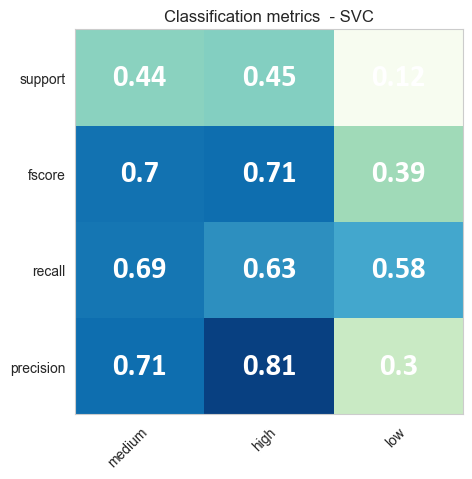

In [208]:
visualize_classification_metrics(test_dataset[goal], svc_gd_pipeline.predict(mca.row_coordinates(test_dataset[features])), 
                                 labels, 'SVC')

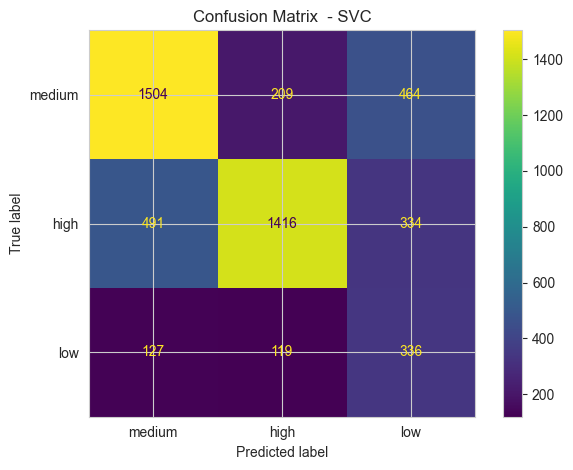

In [209]:
visualize_confusion_matrix(test_dataset[goal], svc_gd_pipeline.predict(mca.row_coordinates(test_dataset[features])), 
                                 labels, 'SVC')

### Drzewo losowe 

In [201]:
from sklearn.ensemble import RandomForestClassifier

rdf_grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid={
                      'n_estimators': [10, 50, 100],
                      'max_depth': [None, 6, 12],
                      'max_features': [None, 'log2']
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

rdf_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', rdf_grid_search)
])

rdf_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'max_depth': [None, 6, 12],
                                          'max_features': [None, 'log2'],
                                          'n_estimators': [10, 50, 100]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [202]:
rfc_res = pd.DataFrame.from_dict(rdf_gs_pipeline.named_steps['estimator'].cv_results_)

In [204]:
rfc_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy',
       'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy',
       'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy',
       'std_test_balanced_accuracy', 'rank_test_balanced_accuracy'],
      dtype='object')

In [205]:
rfc_res[['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_accuracy,mean_test_balanced_accuracy
0,NaN,None,10,0.968867,0.959943
1,NaN,None,50,0.968000,0.959599
2,NaN,None,100,0.967467,0.959184
3,NaN,log2,10,0.967800,0.959290
4,NaN,log2,50,0.967267,0.959023
5,NaN,log2,100,0.967933,0.959812
6,6.0,None,10,0.825133,0.755961
7,6.0,None,50,0.826133,0.754355
8,6.0,None,100,0.821200,0.751325
9,6.0,log2,10,0.818667,0.756006


### Porównanie algorytmów 

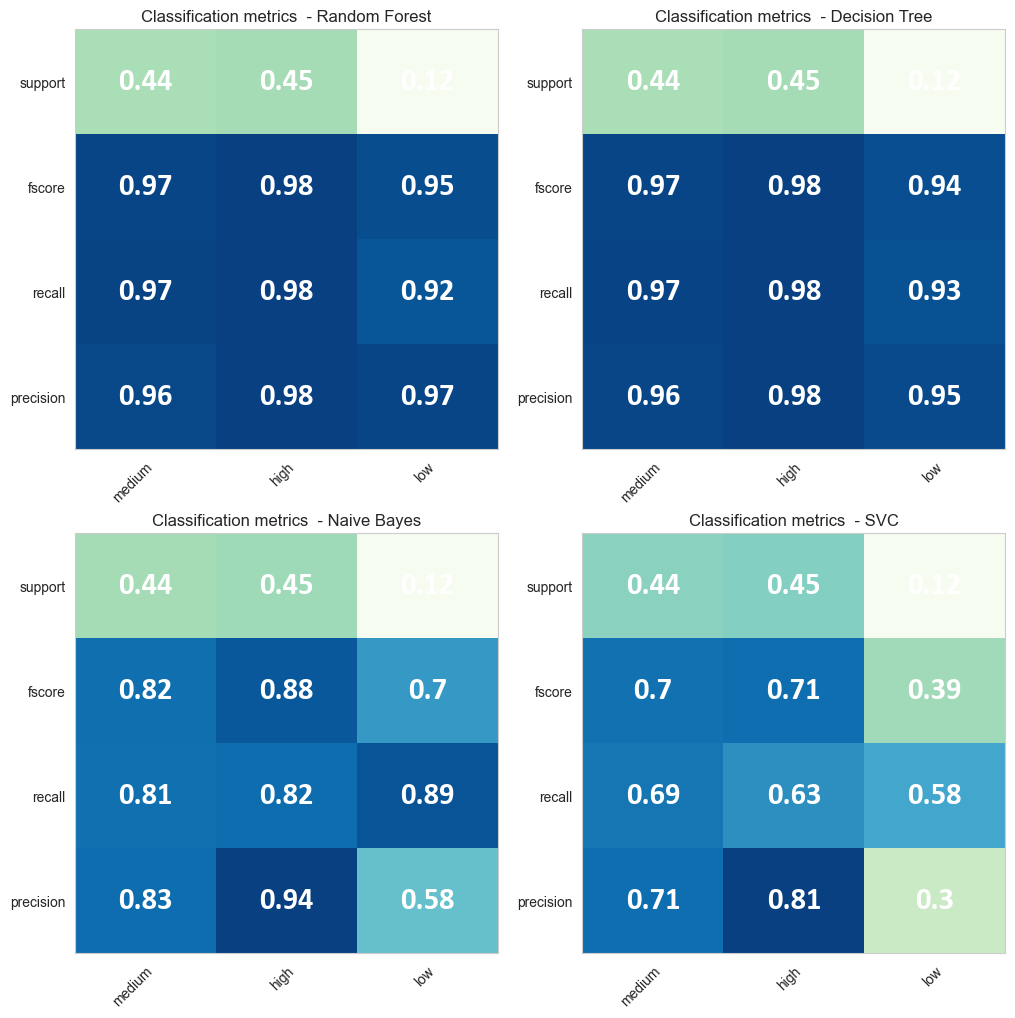

In [218]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
visualize_classification_metrics(test_dataset[goal], rdf_gs_pipeline.predict(test_dataset[features]), labels, 'Random Forest', ax=axes[0, 0])
visualize_classification_metrics(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels, 'Decision Tree', ax=axes[0, 1])
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Naive Bayes', ax=axes[1, 0])
visualize_classification_metrics(test_dataset[goal], svc_gd_pipeline.predict(mca.row_coordinates(test_dataset[features])), labels, 'SVC', ax=axes[1, 1])

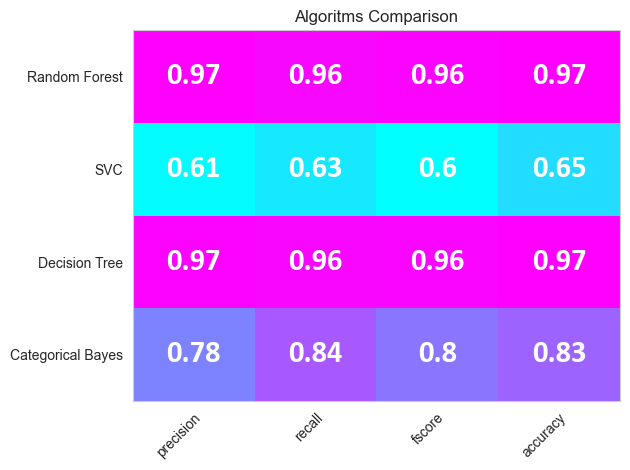

[0.9701049672173475, 0.959522864915643, 0.9646350558894657, 0.971]

In [219]:
visualize_compare_algorithms(
    test_dataset[features], test_dataset[goal],
    [cat_nb_gs_pipeline, dt_clf_gd_pipe, SVCWrapper(svc_gd_pipeline), rdf_gs_pipeline],
    ['Categorical Bayes', 'Decision Tree', 'SVC', 'Random Forest']
)